In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import zipfile

# Plant Generation Data
df_gen = pd.read_csv('Plant_2_Generation_Data.csv')

# Plant Weather Data
df_weather = pd.read_csv('Plant_2_Weather_Sensor_Data.csv') 

In [10]:
df_gen.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07


In [11]:
df_weather.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


In [12]:
df_gen.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,67698.0,67698.000000,67698.000000,67698.000000,6.769800e+04
mean,4136001.0,246.701961,241.277825,3294.890295,6.589448e+08
std,0.0,370.569597,362.112118,2919.448386,7.296678e+08
min,4136001.0,0.000000,0.000000,0.000000,0.000000e+00
25%,4136001.0,0.000000,0.000000,272.750000,1.996494e+07
50%,4136001.0,0.000000,0.000000,2911.000000,2.826276e+08
75%,4136001.0,446.591667,438.215000,5534.000000,1.348495e+09
max,4136001.0,1420.933333,1385.420000,9873.000000,2.247916e+09


In [ ]:
df_weather.describe()

,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3259.0,3259.000000,3259.000000,3259.000000
mean,4136001.0,28.069400,32.772408,0.232737
std,0.0,4.061556,11.344034,0.312693
min,4136001.0,20.942385,20.265123,0.000000
25%,4136001.0,24.602135,23.716881,0.000000
50%,4136001.0,26.981263,27.534606,0.019040
75%,4136001.0,31.056757,40.480653,0.438717
max,4136001.0,39.181638,66.635953,1.098766


In [14]:
print('Plant ID ',df_gen.PLANT_ID.nunique())
print('No. of Inverters ',df_gen.SOURCE_KEY.nunique())
print('No. of Unique Source key',df_weather.SOURCE_KEY.nunique())
print('Null values in generation data: \n',df_gen.isnull().sum())
print('Null values in generation data: \n',df_weather.isnull().sum()) 

Plant ID  1
No. of Inverters  22
No. of Unique Source key 1
Null values in generation data: 
 DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
Null values in generation data: 
 DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [15]:
df_gen.drop('PLANT_ID', axis=1, inplace=True)
df_weather.drop('PLANT_ID', axis = 1, inplace=True)

## Mapping
Inverter_labels = {inverter_no:inverter_name for inverter_name,inverter_no in enumerate(df_gen['SOURCE_KEY'].unique(),1)}
df_gen['Inverter_No'] = df_gen['SOURCE_KEY'].map(Inverter_labels) 

## Drop Source Key after replacing with inverter numbers
df_gen.drop('SOURCE_KEY',axis=1,inplace=True)
df_weather.drop('SOURCE_KEY',axis=1,inplace=True) 
#Reordering and dropping Daily yield and Total yield
df_gen = df_gen[['DATE_TIME','Inverter_No' ,'DC_POWER', 'AC_POWER']]

In [16]:
print('Inverter {} has data for {} timestamps(Minimum)'.
      format(df_gen.groupby('Inverter_No')['DATE_TIME'].count().argmin()+1,df_gen.groupby('Inverter_No')['DATE_TIME'].count().min()))
print('Inverter {} has data for {} timestamps(Maximum)'.
      format(df_gen.groupby('Inverter_No')['DATE_TIME'].count().argmax()+1,df_gen.groupby('Inverter_No')['DATE_TIME'].count().max()))     
print('DIFFERENCE = {}'.format(df_gen.groupby('Inverter_No')['DATE_TIME'].count().max() - 
                               df_gen.groupby('Inverter_No')['DATE_TIME'].count().min()))

Inverter 5 has data for 2355 timestamps(Minimum)
Inverter 2 has data for 3259 timestamps(Maximum)
DIFFERENCE = 904


In [17]:
from functools import reduce

grouped = df_gen.groupby('Inverter_No')

## Making a list of each Inverter group 
dfs = list()
for i in df_gen['Inverter_No'].unique():
    dfs.append(grouped.get_group(i))
  

 ## Merging data inverterwise using 'reduce'
 ## Applying merge function to all of the list elements of 'dfs' in the sequence passed.

# df_new = reduce(lambda left,right: pd.merge(left,right,on=['DATE_TIME'],how='outer'),dfs)
dfs_renamed = []
for i, df in enumerate(dfs, start=1):
    df = df.rename(columns={
        col: f"{col}_inv{i}" for col in df.columns if col != "DATE_TIME"
    })
    dfs_renamed.append(df)

df_new = reduce(lambda left, right: pd.merge(left, right, on="DATE_TIME", how="outer"), dfs_renamed)


display(df_new)
#Rename columns
df_new.columns = ['DATE_TIME',
        'DC_POWER_1', 'AC_POWER_1',
        'Inverter_No_1', 'DC_POWER_2', 'AC_POWER_2',
        'Inverter_No_2', 'DC_POWER_3', 'AC_POWER_3',
        'Inverter_No_3', 'DC_POWER_4', 'AC_POWER_4',
        'Inverter_No_4', 'DC_POWER_5', 'AC_POWER_5',
        'Inverter_No_5', 'DC_POWER_6', 'AC_POWER_6',
        'Inverter_No_6', 'DC_POWER_7', 'AC_POWER_7',
        'Inverter_No_7', 'DC_POWER_8', 'AC_POWER_8',
        'Inverter_No_8', 'DC_POWER_9', 'AC_POWER_9',
        'Inverter_No_9', 'DC_POWER_10', 'AC_POWER_10',
        'Inverter_No_10', 'DC_POWER_11', 'AC_POWER_11',
        'Inverter_No_11', 'DC_POWER_12', 'AC_POWER_12',
        'Inverter_No_12', 'DC_POWER_13', 'AC_POWER_13',
        'Inverter_No_13', 'DC_POWER_14', 'AC_POWER_14',
        'Inverter_No_14', 'DC_POWER_15', 'AC_POWER_15',
        'Inverter_No_15', 'DC_POWER_16', 'AC_POWER_16',
        'Inverter_No_16', 'DC_POWER_17', 'AC_POWER_17',
        'Inverter_No_17', 'DC_POWER_18', 'AC_POWER_18',
        'Inverter_No_18', 'DC_POWER_19', 'AC_POWER_19',
        'Inverter_No_19', 'DC_POWER_20', 'AC_POWER_20',
        'Inverter_No_20', 'DC_POWER_21', 'AC_POWER_21',
        'Inverter_No_21', 'DC_POWER_22', 'AC_POWER_22',
        'Inverter_No_22']

,DATE_TIME,Inverter_No_inv1,DC_POWER_inv1,AC_POWER_inv1,Inverter_No_inv2,DC_POWER_inv2,AC_POWER_inv2,Inverter_No_inv3,DC_POWER_inv3,AC_POWER_inv3,...,AC_POWER_inv19,Inverter_No_inv20,DC_POWER_inv20,AC_POWER_inv20,Inverter_No_inv21,DC_POWER_inv21,AC_POWER_inv21,Inverter_No_inv22,DC_POWER_inv22,AC_POWER_inv22
0,2020-05-15 00:00:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
1,2020-05-15 00:15:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
2,2020-05-15 00:30:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3,2020-05-15 00:45:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
4,2020-05-15 01:00:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2020-06-17 22:45:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3255,2020-06-17 23:00:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3256,2020-06-17 23:15:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3257,2020-06-17 23:30:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0


In [18]:
df_weather['DATE_TIME'] = df_weather['DATE_TIME'].astype(str)
df_new['DATE_TIME'] = df_new['DATE_TIME'].astype(str)
#Merging Generation & Weather datasets
df = df_weather.merge(df_new,left_on='DATE_TIME',right_on='DATE_TIME',how='outer')
#Generating 15 min time blocks
tb = pd.date_range('15-05-2020','16-05-2020',freq='15min')
tb=tb[:-1] 
ts = tb.strftime('%H:%M')
block_dict = {}
j=1
for i in range(len(ts)):
    block_dict[ts[i]] =  j
    j+=1

# Making new columns of Time,BLOCK and Date and droping DATE_TIME column
df['TIME'] = df['DATE_TIME'].apply(lambda x:str(x)[-8:-3])
df['DATE'] = pd.to_datetime(df['DATE_TIME']).dt.date
df['BLOCK'] = pd.to_datetime(df['TIME']).astype(str).apply(lambda x:block_dict[str(x)[-8:-3]])
df.drop('DATE_TIME',axis=1,inplace=True)
#Saving the dictionary using numpy
np.save('timestamp_block_dictionary.npy',block_dict)

## Column re-ordering
cols = df.columns.tolist()
df = df[[cols[-1]]+[cols[-2]]+[cols[-3]]+cols[:-3]]

display(df)

,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER_1,AC_POWER_1,Inverter_No_1,DC_POWER_2,...,Inverter_No_19,DC_POWER_20,AC_POWER_20,Inverter_No_20,DC_POWER_21,AC_POWER_21,Inverter_No_21,DC_POWER_22,AC_POWER_22,Inverter_No_22
0,1,2020-05-15,00:00,27.004764,25.060789,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
1,2,2020-05-15,00:15,26.880811,24.421869,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
2,3,2020-05-15,00:30,26.682055,24.427290,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3,4,2020-05-15,00:45,26.500589,24.420678,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
4,5,2020-05-15,01:00,26.596148,25.088210,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,92,2020-06-17,22:45,23.511703,22.856201,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3255,93,2020-06-17,23:00,23.482282,22.744190,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3256,94,2020-06-17,23:15,23.354743,22.492245,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3257,95,2020-06-17,23:30,23.291048,22.373909,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0


In [19]:
#Getting last 3 days data 
last_3_days = df['DATE'].astype(str).unique()[-3:]
df_test = df[df['DATE'].astype(str).isin(last_3_days)].sort_values(by=['DATE','BLOCK'])
#Saving Test data
df_test.reset_index(drop=True).to_csv('Test_data.csv')
#Saving all as Train for indexes not present in test data
df_train = df[~df.index.isin(df_test.index)]
df_train.to_csv('Train_data.csv')

## Checking shapes
print('Train:',df_train.shape)
print('Test:',df_test.shape)

## Check for missing values
print('No. of missing values in train dataset: ',list(df_train.isnull().sum()))

Train: (2971, 72)
Test: (288, 72)
No. of missing values in train dataset:  [0, 0, 0, 0, 0, 0, 64, 64, 64, 0, 0, 0, 0, 0, 0, 64, 64, 64, 904, 904, 904, 0, 0, 0, 0, 0, 0, 64, 64, 64, 904, 904, 904, 0, 0, 0, 64, 64, 64, 64, 64, 64, 0, 0, 0, 0, 0, 0, 904, 904, 904, 64, 64, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 904, 904, 904, 0, 0, 0]


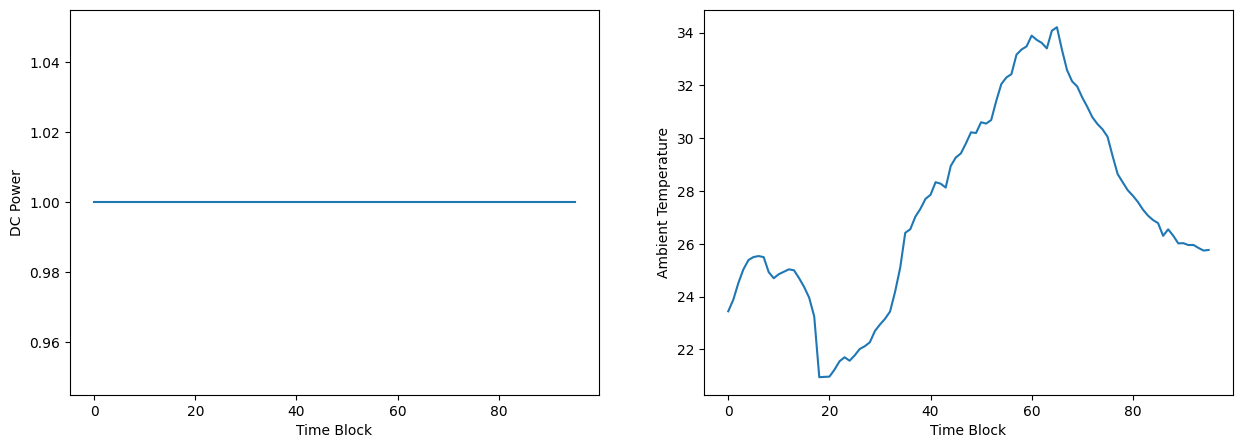

In [20]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(df_train[df_train['DATE'].astype(str)=='2020-05-18'].reset_index(drop=True)['DC_POWER_1'])
ax2.plot(df_train[df_train['DATE'].astype(str)=='2020-05-18'].reset_index(drop=True)['AMBIENT_TEMPERATURE'])
ax1.set_xlabel('Time Block')
ax1.set_ylabel('DC Power')

ax2.set_xlabel('Time Block')
ax2.set_ylabel('Ambient Temperature')

plt.show()

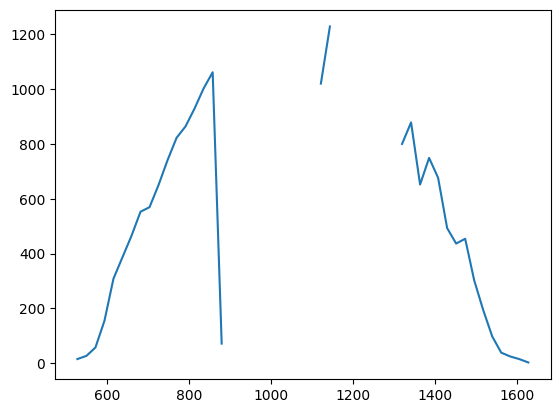

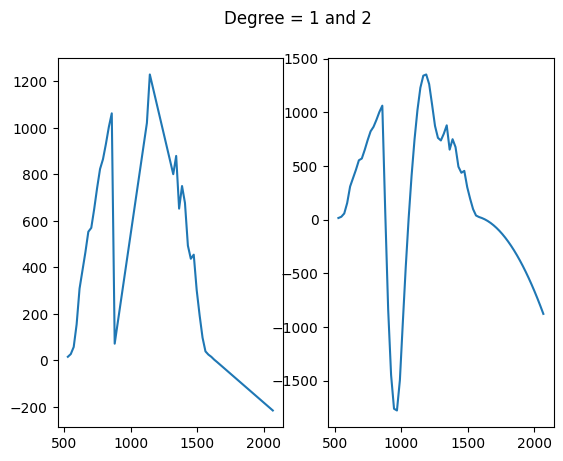

In [21]:
df2 = df_gen.copy() # Making a acopy 
df2['DATE'] = pd.to_datetime(df_gen['DATE_TIME']).dt.date.astype(str)
## Selecting a date and replacing AC Power with NaN wherever its 0 and plotting 
indexes = df2[(df2['Inverter_No']==1)&(df2['DATE']=='2020-05-15')&(df2['AC_POWER']==0)].index
df2.loc[indexes,'AC_POWER']=np.nan
df2 = df2[(df2['Inverter_No']==1)&(df2['DATE']=='2020-05-15')]['AC_POWER']
df2.plot();

#Code for Plot 2
## Comparison between 1 & 2 degree splines
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Degree = 1 and 2')
ax1.plot(df2.interpolate(method='spline',order=1))
ax2.plot(df2.interpolate(method='spline',order=2));

In [22]:
day_only_columns=list()
#Will collect all names like DC_POWER_1, DC_POWER_2 and so on 
DC_cols = [i for i in df.columns if 'DC_POWER' in i]
AC_cols = [i for i in df.columns if 'AC_POWER' in i]
day_only_columns = DC_cols+AC_cols+["IRRADIATION"]

def Data_Preparation_Plant_Level(df):
    for col in day_only_columns:
        df[col] = df[col].astype(float)
        # For time except for non-generating hours(12 am to 6 am & 6 pm to 12 am) will be replaced by zero
        df.loc[df[(~((df['BLOCK']>24) & (df['BLOCK']<73))) & df[col].isnull()].index,col] = 0

    # Left NaN value for generating hours(6 am to 6pm) 
       
        #1.AC & DC columns
    df[DC_cols+AC_cols].interpolate(method='polynomial',order = 2,inplace=True)
       #2.Left NaN values in Irradiation, Ambient Temp, Module Temp, Inverter_No
    df.interpolate(method='linear',inplace=True)
    
    # Summing up Inverter wise AC and DC values to reach Plant-level generation
    df['AC_POWER'] = df.loc[: ,AC_cols].sum(axis=1)
    df['DC_POWER'] = df.loc[:,DC_cols].sum(axis=1)
    #Scaling generation to MW from kW  
    df['AC_POWER'] = df['AC_POWER']/1000
    df['DC_POWER'] = df['DC_POWER']/1000
    
    return df
#Applying the function on Train & Test 
df_train = Data_Preparation_Plant_Level(df_train)
df_test = Data_Preparation_Plant_Level(df_test)

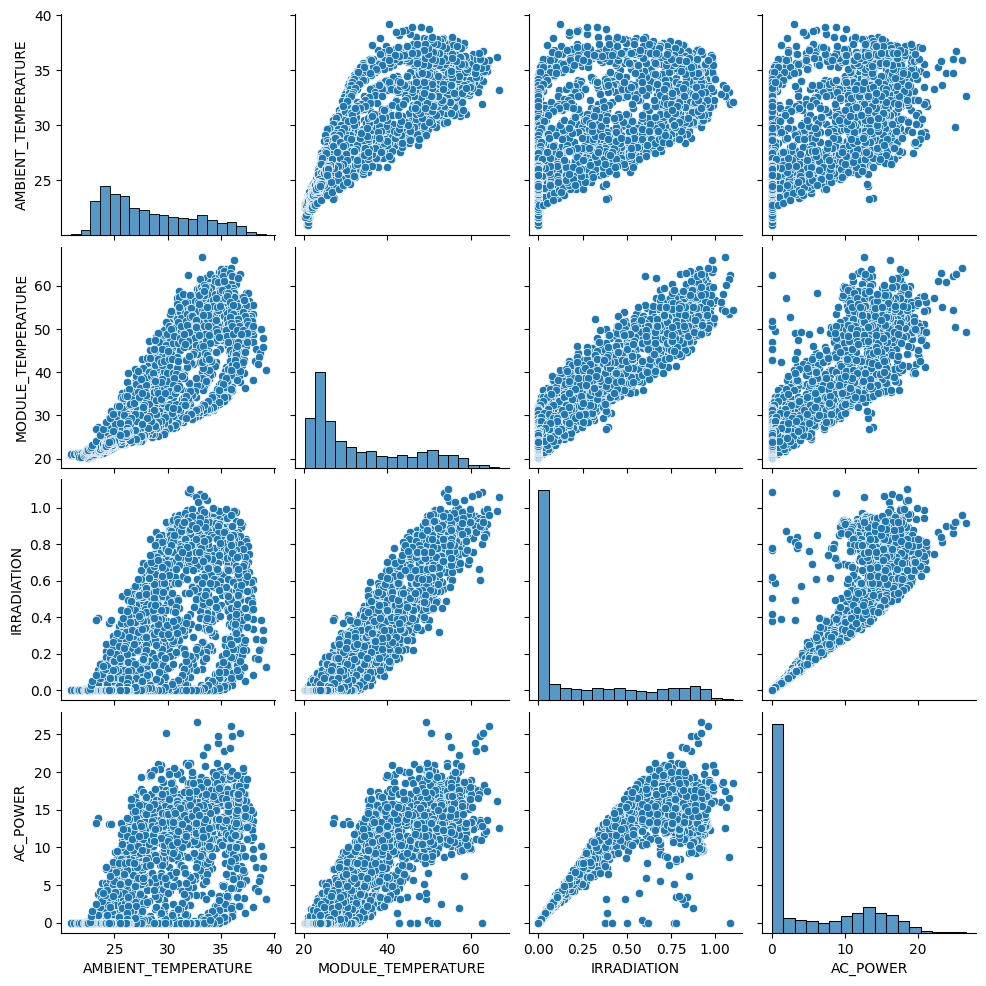

In [23]:
import seaborn as sns
sns.pairplot(df_train[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
       'IRRADIATION','AC_POWER']],height=2.5)

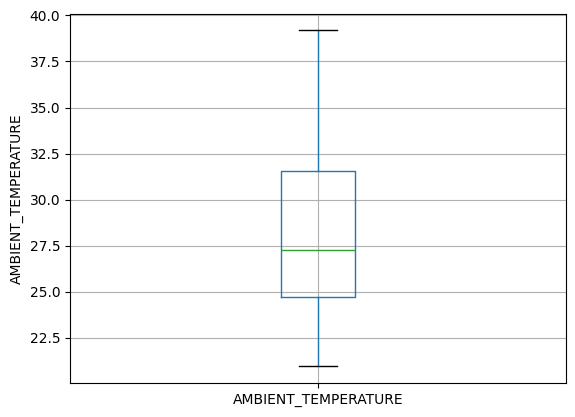

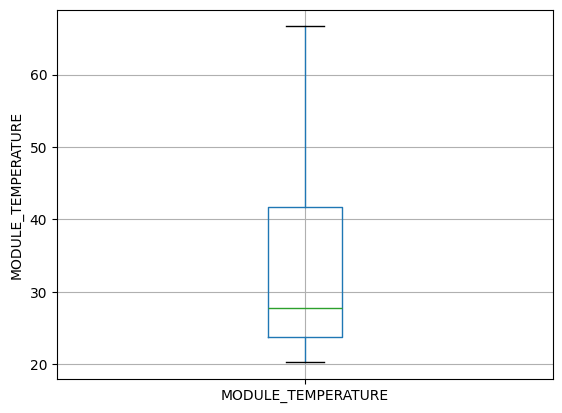

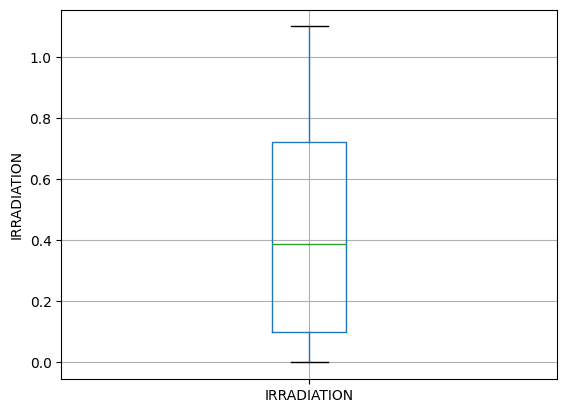

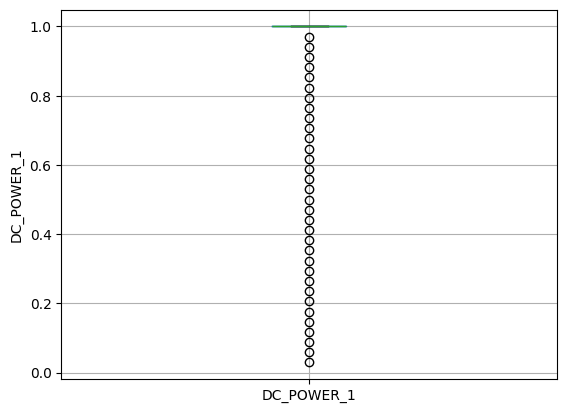

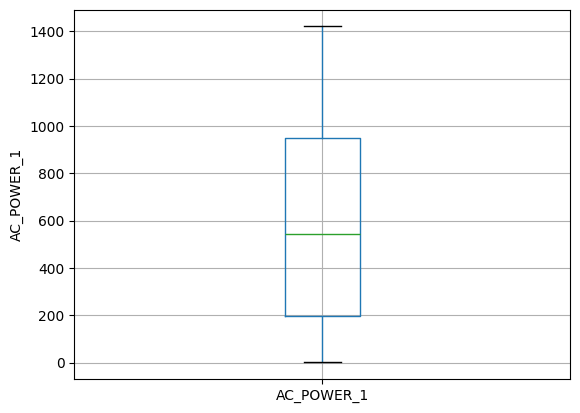

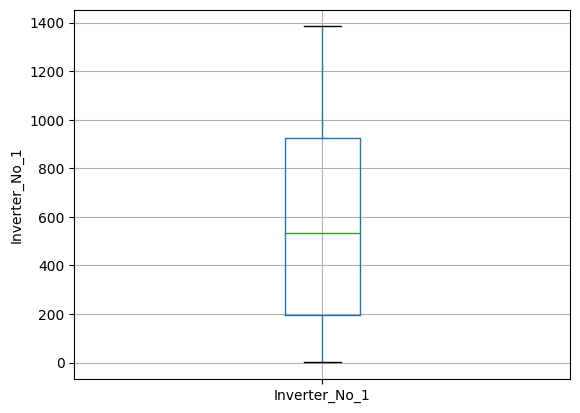

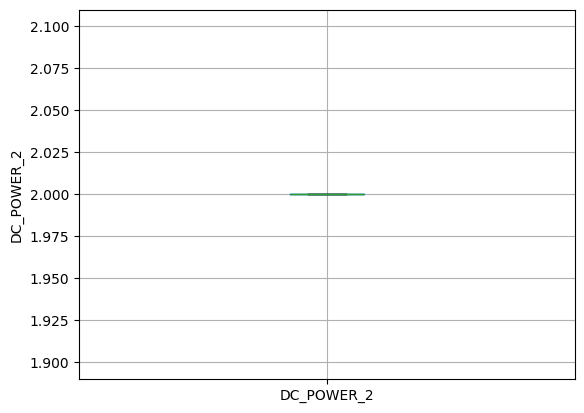

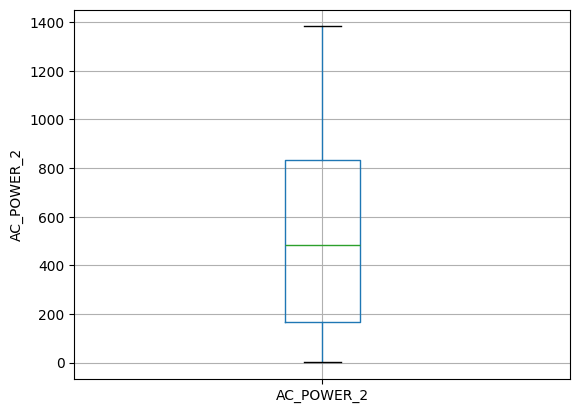

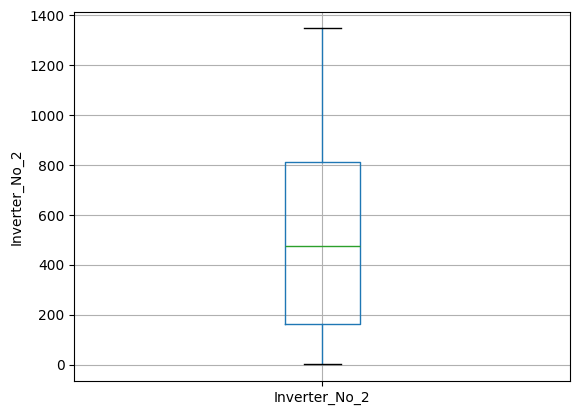

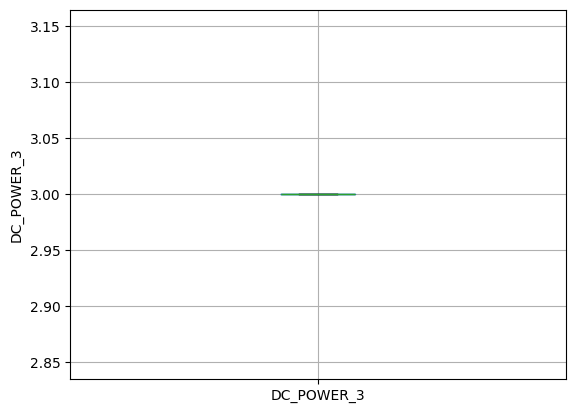

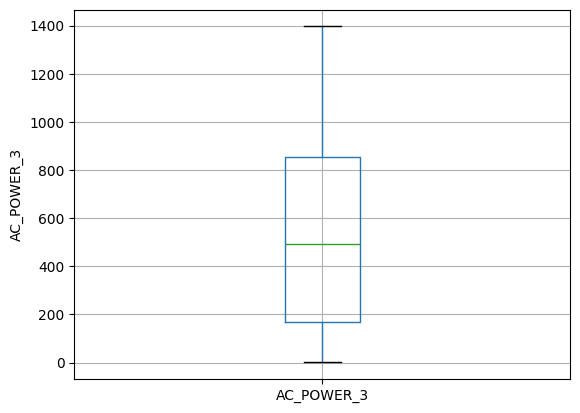

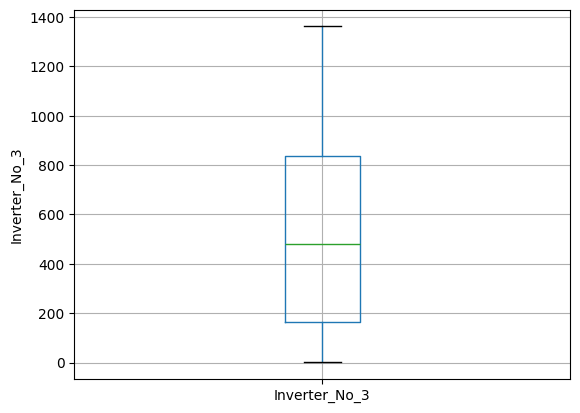

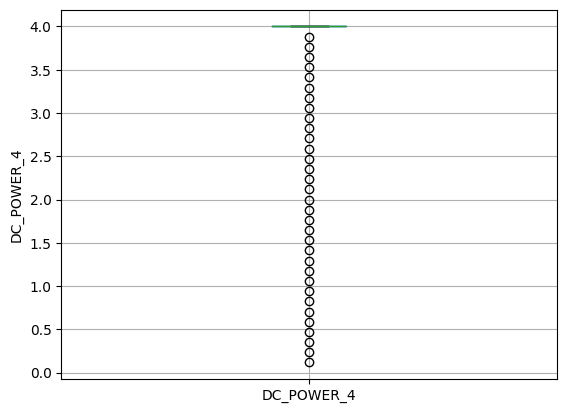

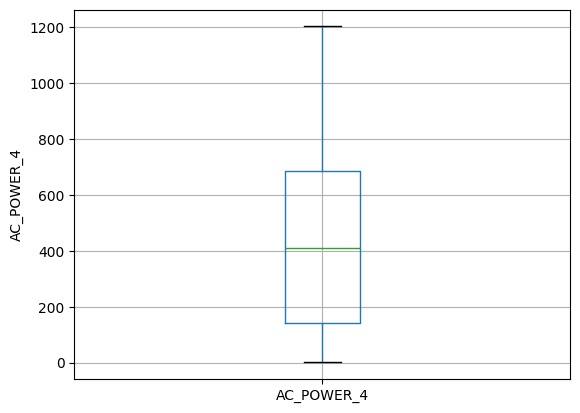

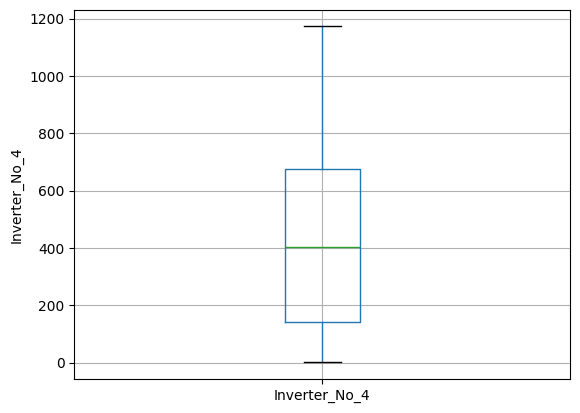

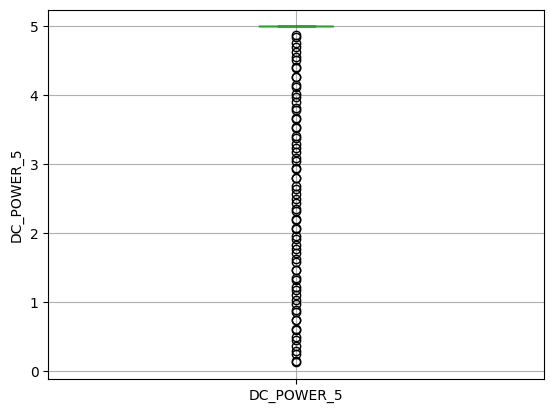

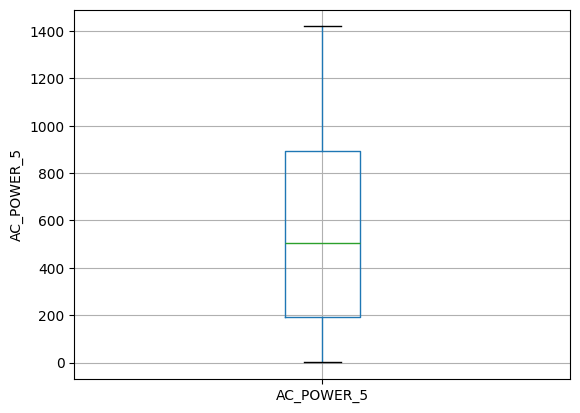

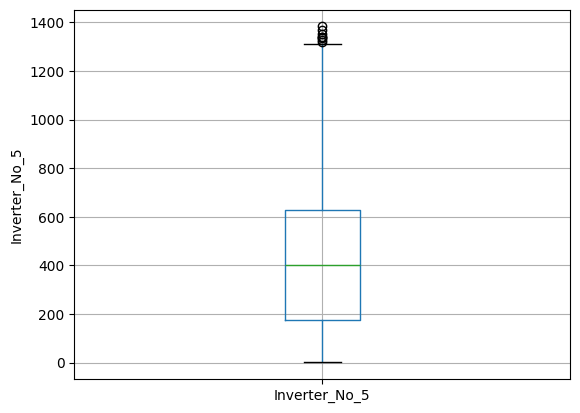

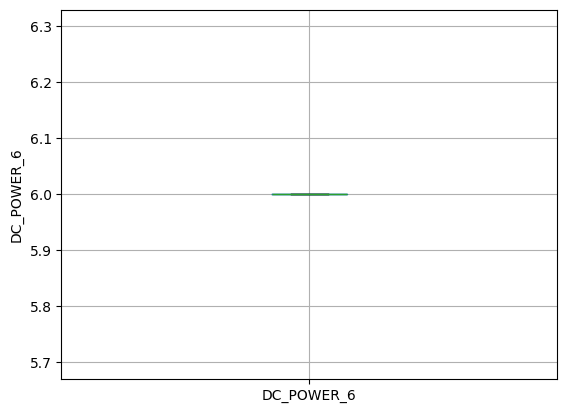

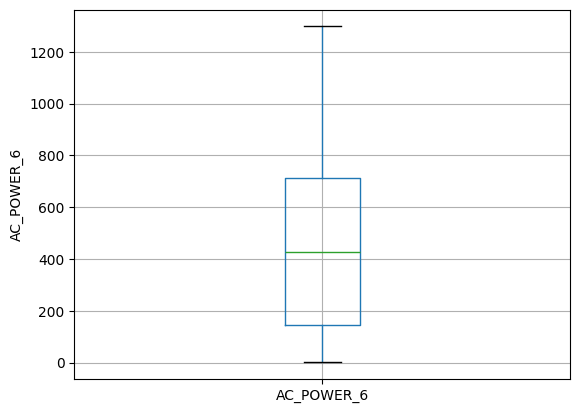

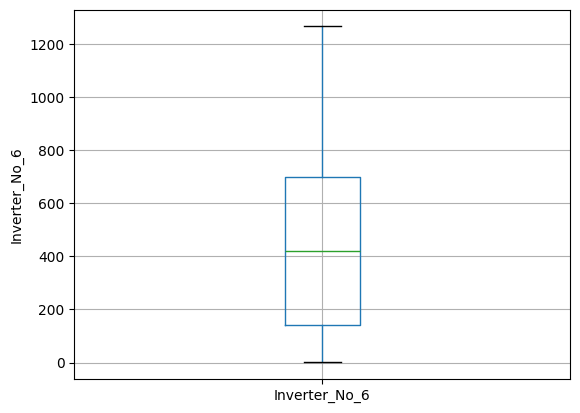

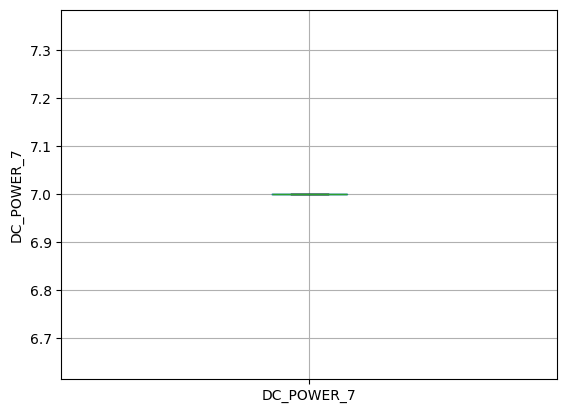

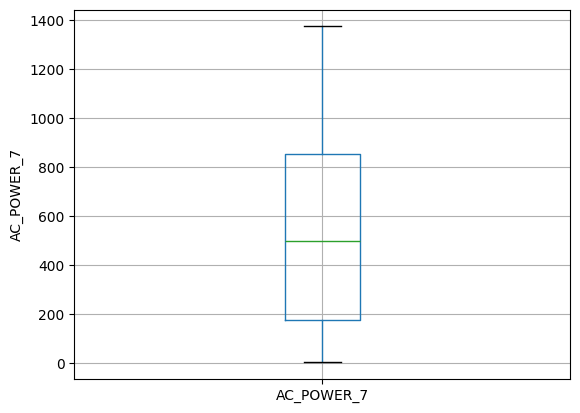

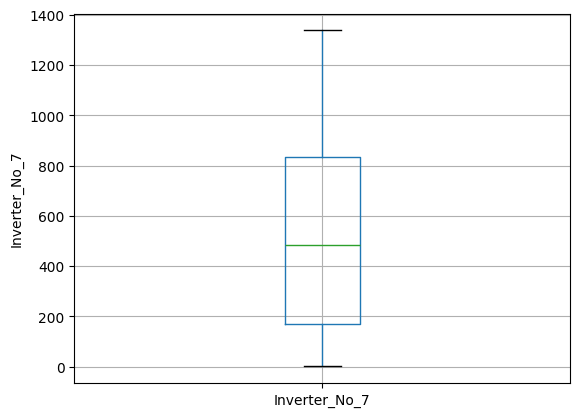

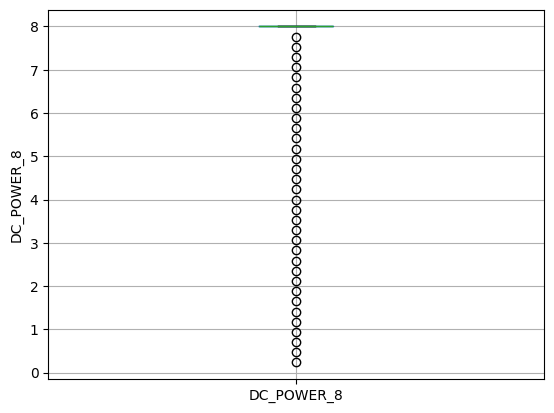

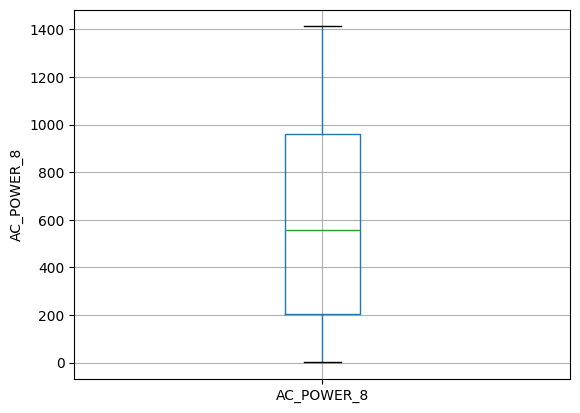

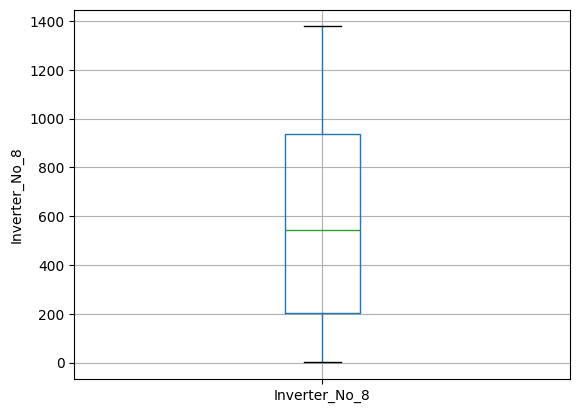

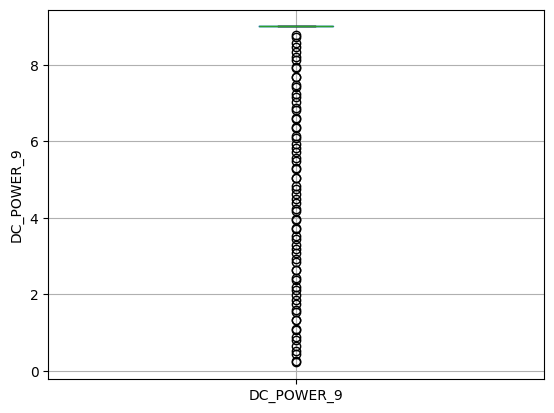

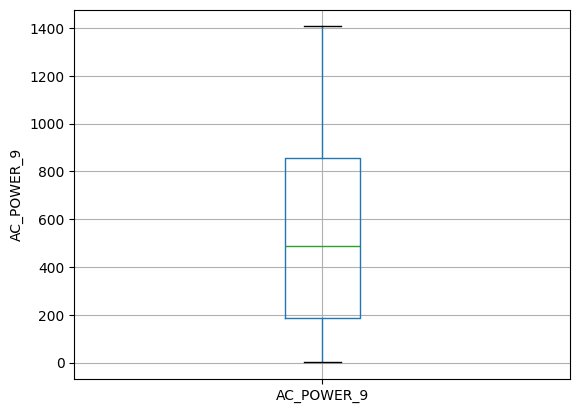

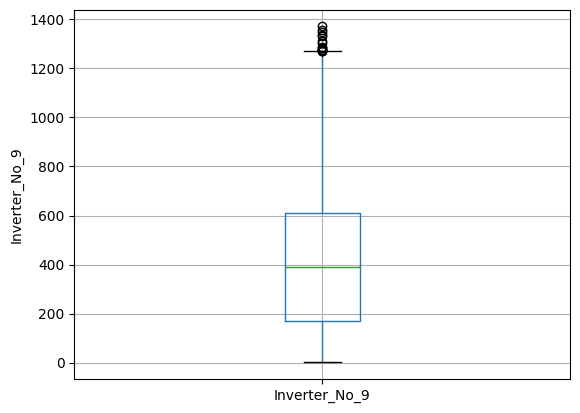

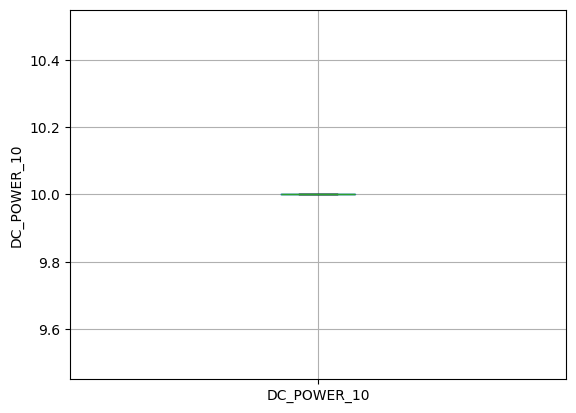

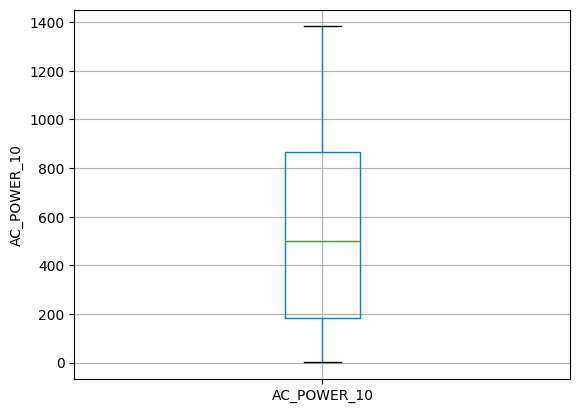

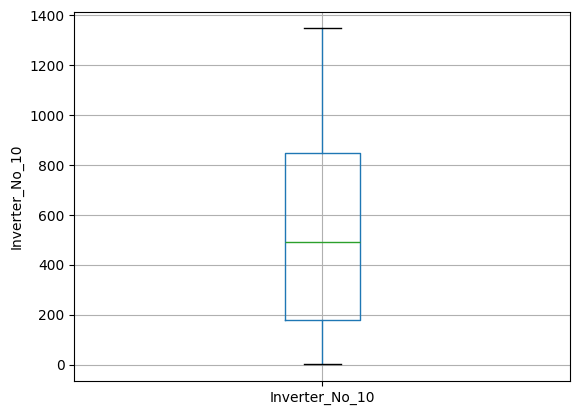

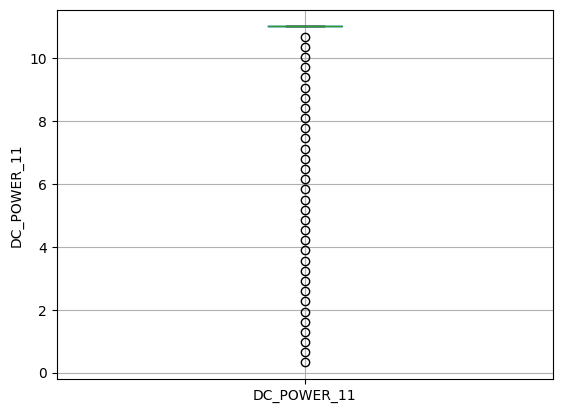

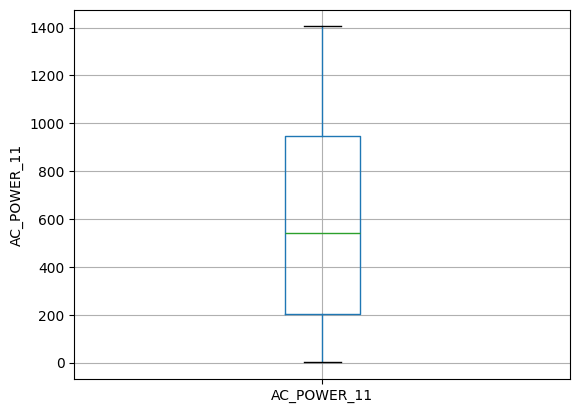

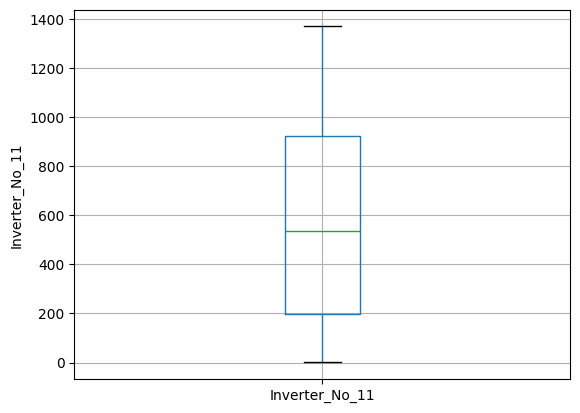

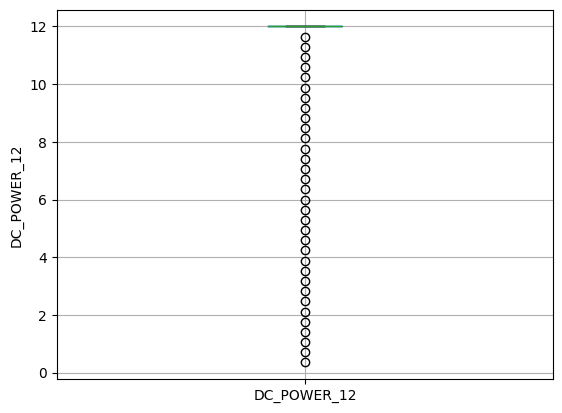

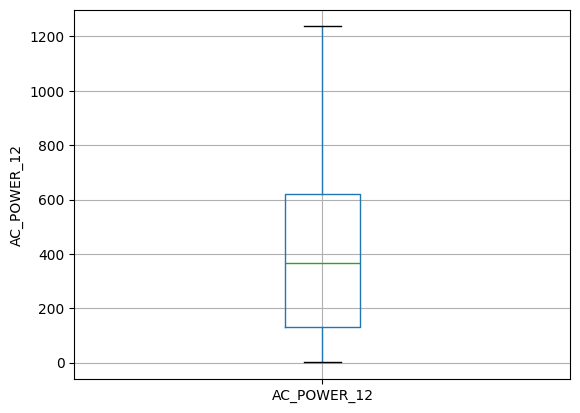

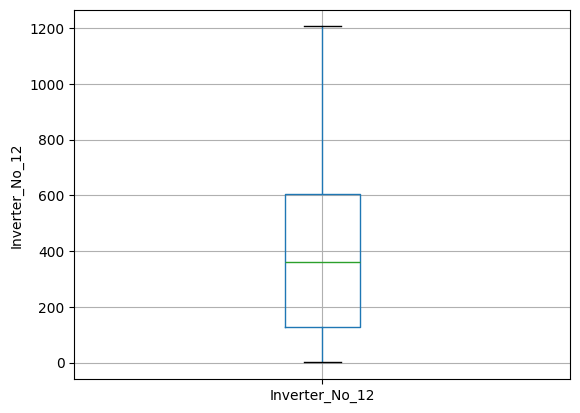

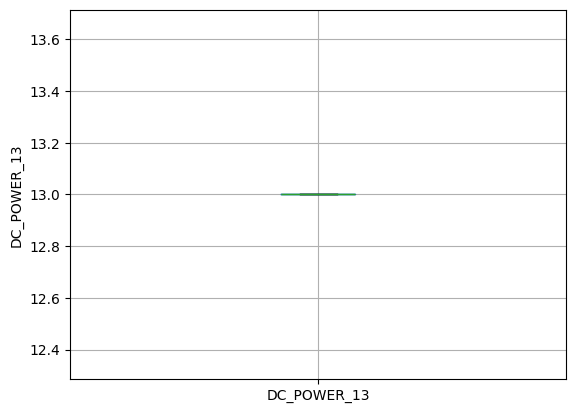

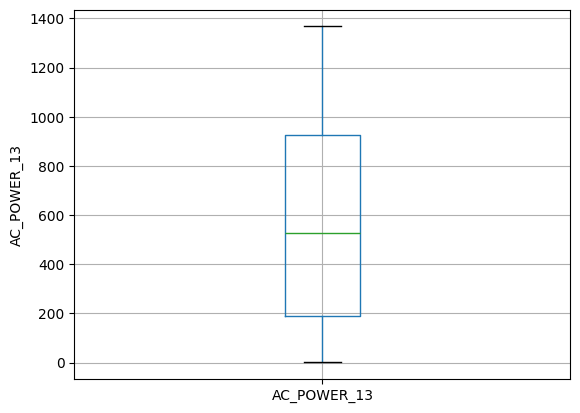

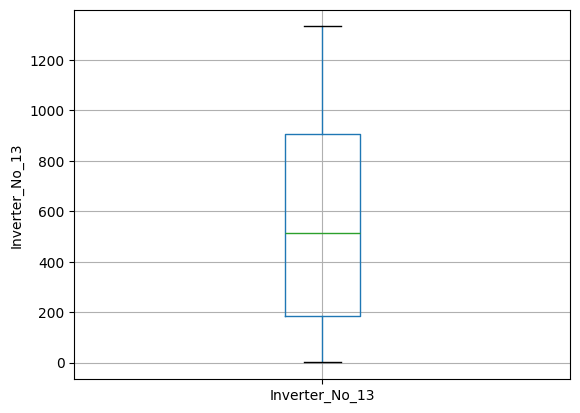

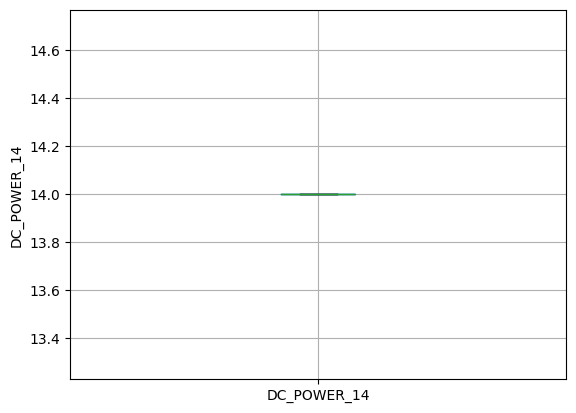

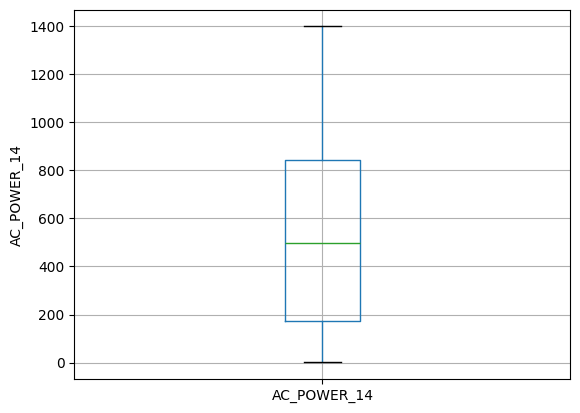

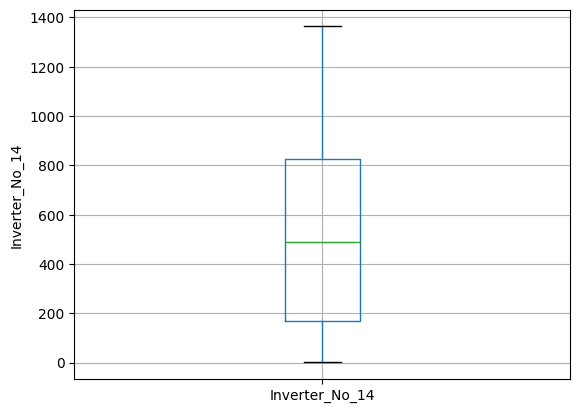

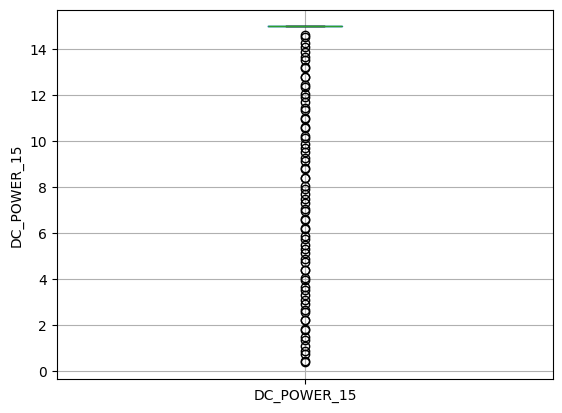

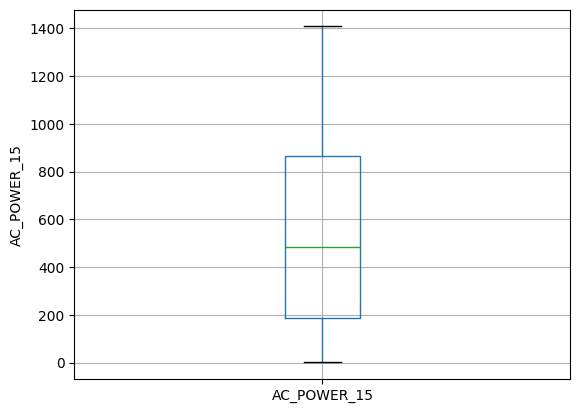

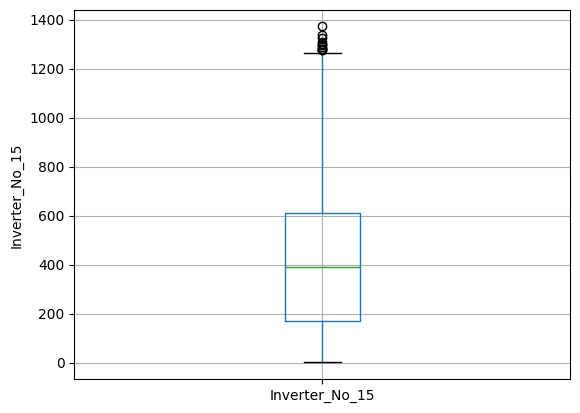

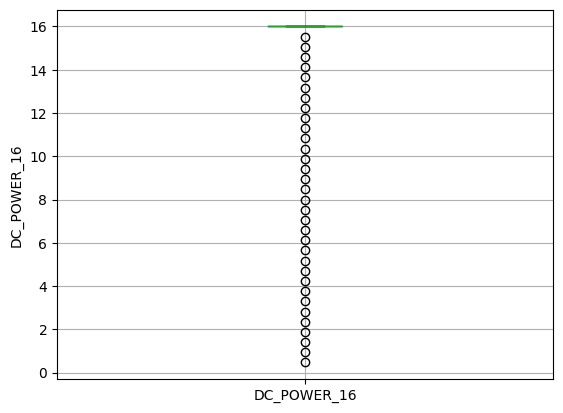

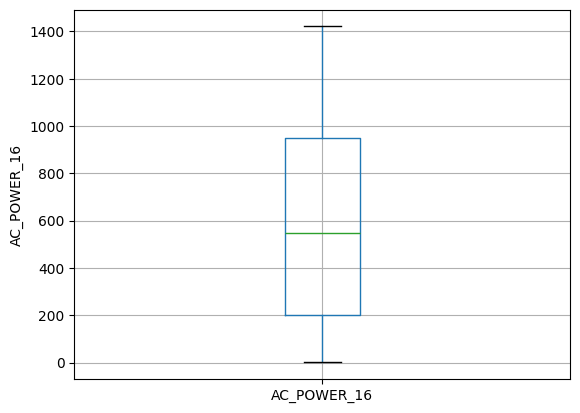

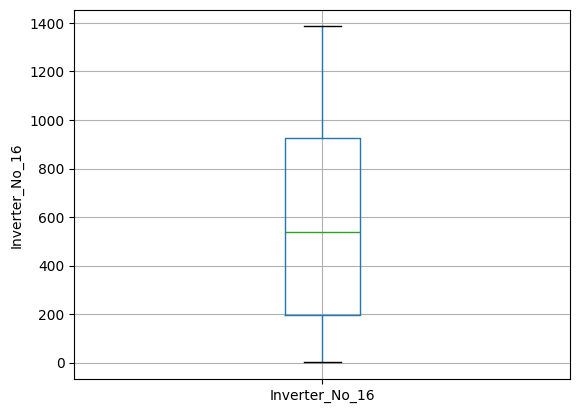

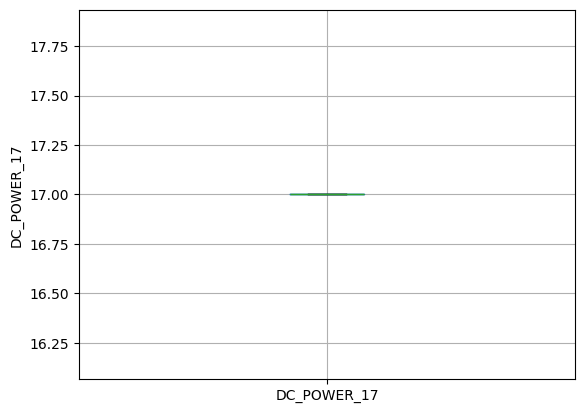

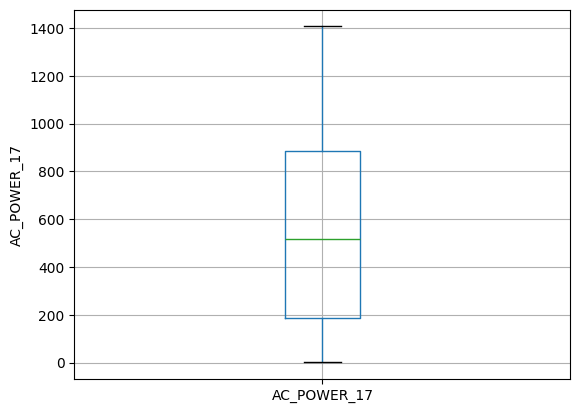

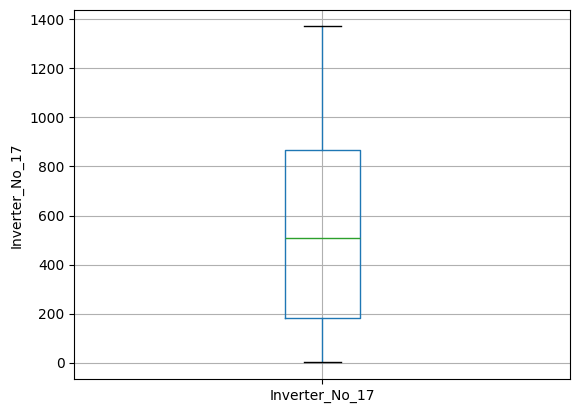

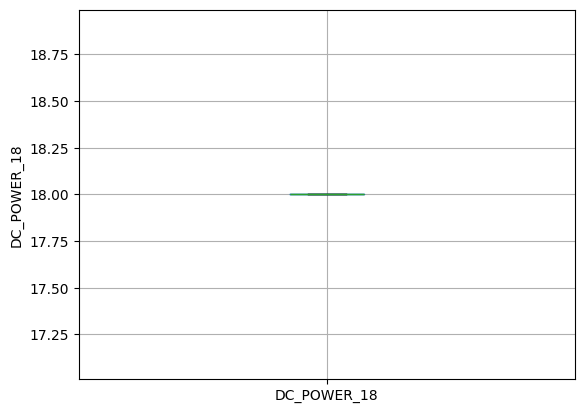

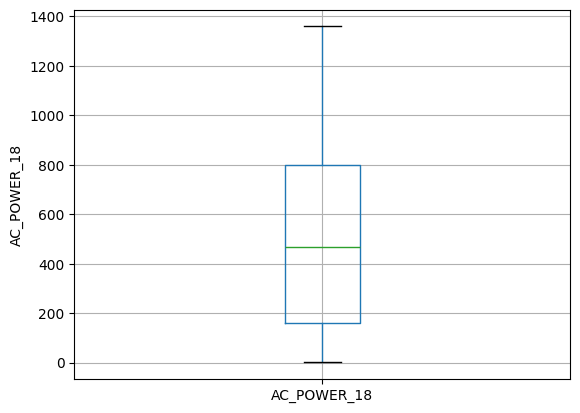

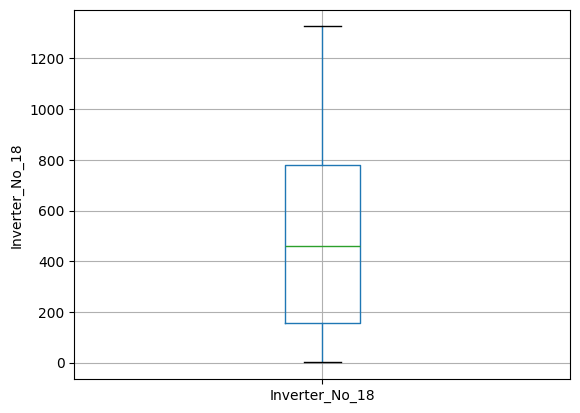

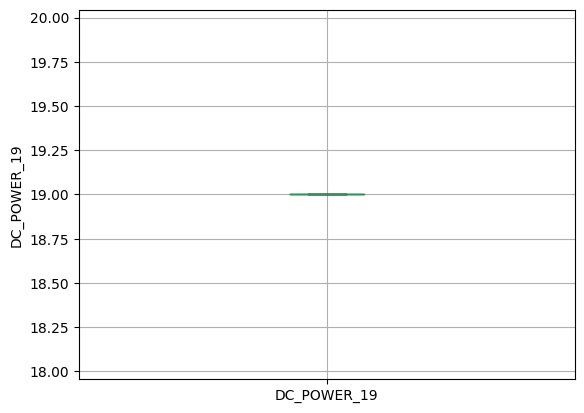

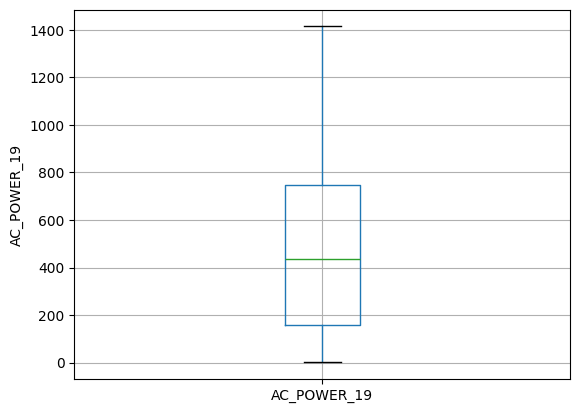

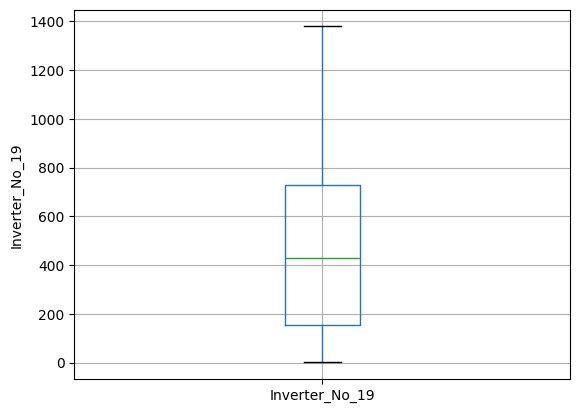

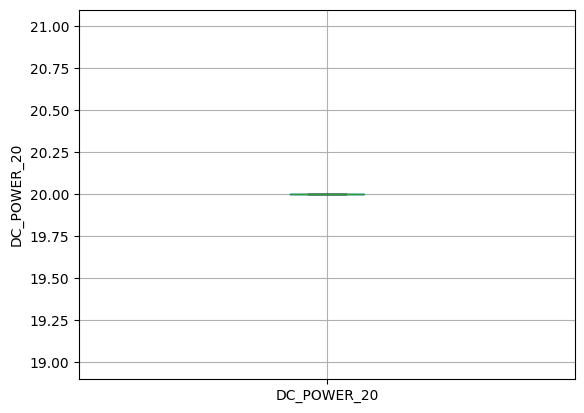

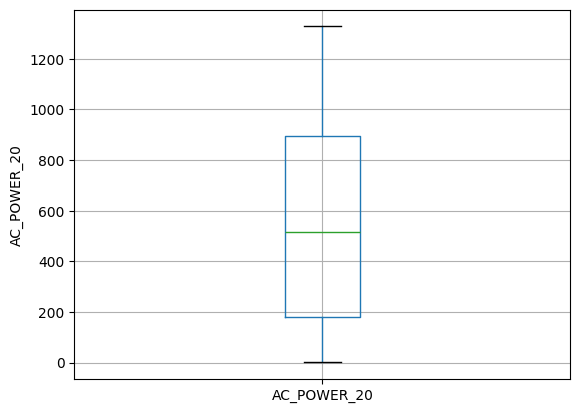

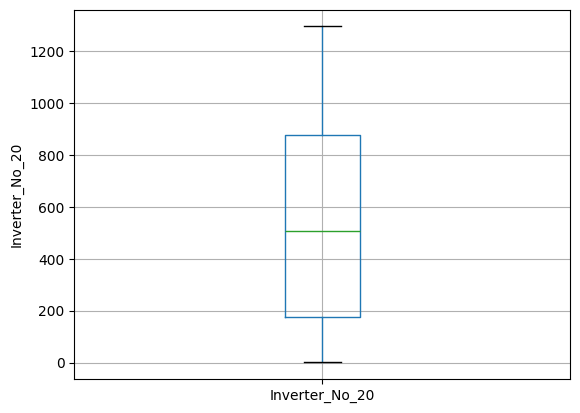

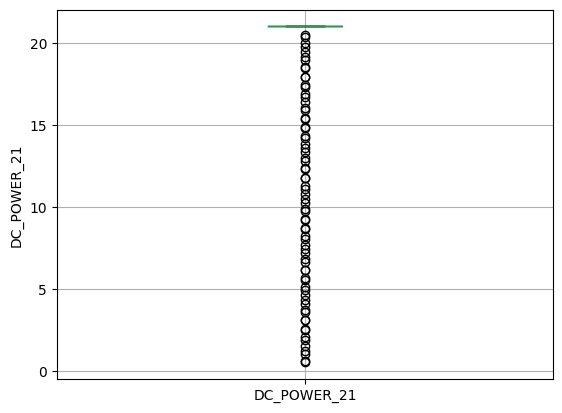

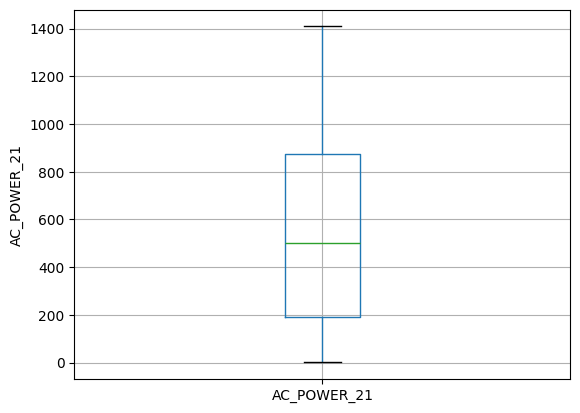

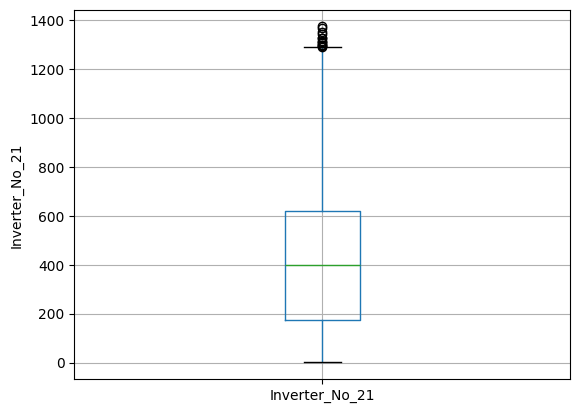

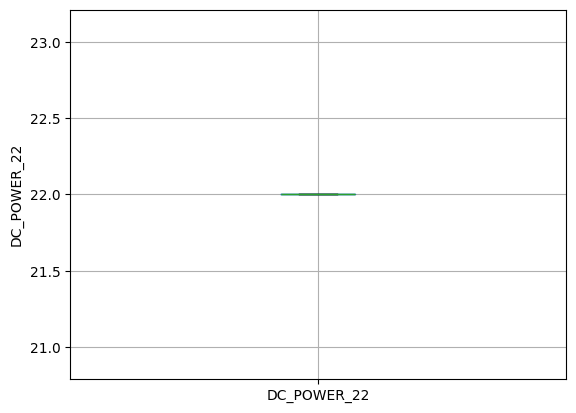

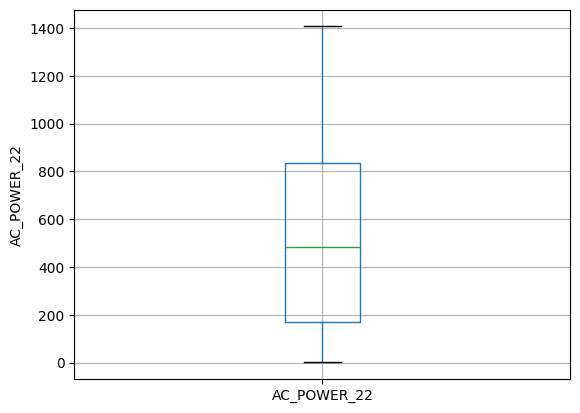

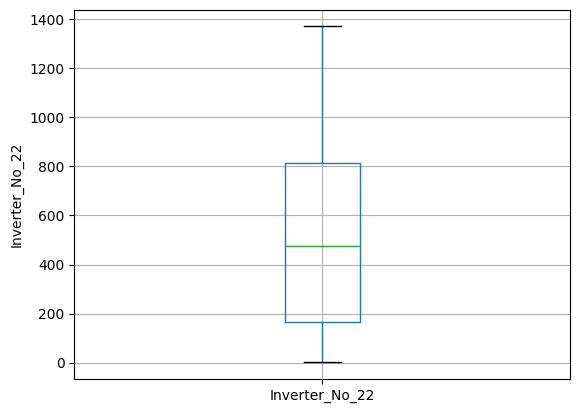

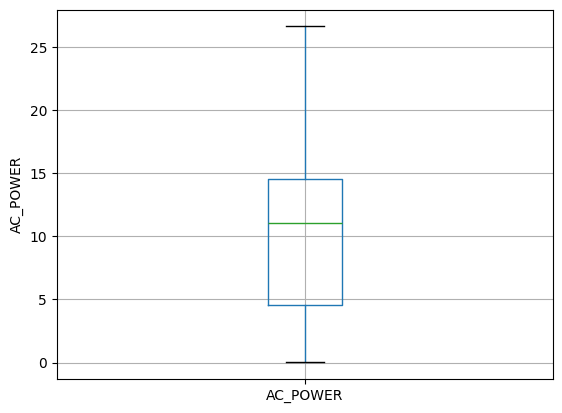

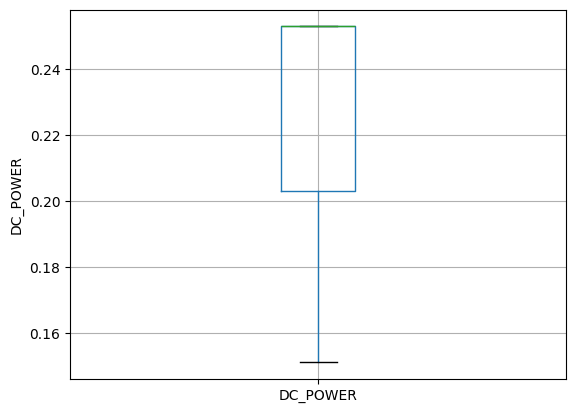

In [24]:
for feature in df_train.columns[3:]:
    # ignoring zero values for plotting
    df_train[df_train[feature]!=0].boxplot(column=feature)
    plt.ylabel(feature)
    plt.show()

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER_1,AC_POWER_1,Inverter_No_1,DC_POWER_2,AC_POWER_2,Inverter_No_2,DC_POWER_3,...,AC_POWER_20,Inverter_No_20,DC_POWER_21,AC_POWER_21,Inverter_No_21,DC_POWER_22,AC_POWER_22,Inverter_No_22,AC_POWER,DC_POWER
AMBIENT_TEMPERATURE,1.000000,0.842631,0.660469,0.108704,0.588689,0.577037,NaN,0.482133,0.482228,NaN,...,0.552329,0.552438,-0.224663,0.424587,0.536219,NaN,0.534155,0.534207,0.652054,-0.180352
MODULE_TEMPERATURE,0.842631,1.000000,0.947146,0.072692,0.827335,0.819616,NaN,0.671758,0.671674,NaN,...,0.739794,0.739737,-0.127817,0.633127,0.703032,NaN,0.713459,0.713336,0.885174,-0.099883
IRRADIATION,0.660469,0.947146,1.000000,0.034885,0.853650,0.850426,NaN,0.716132,0.715961,NaN,...,0.795831,0.795679,-0.067729,0.692068,0.736888,NaN,0.736880,0.736718,0.923922,-0.053839
DC_POWER_1,0.108704,0.072692,0.034885,1.000000,0.050300,-0.049536,NaN,0.046002,0.045998,NaN,...,0.015723,0.015784,0.177898,0.028878,-0.050252,NaN,0.064239,0.064252,0.050693,0.415595
AC_POWER_1,0.588689,0.827335,0.853650,0.050300,1.000000,0.993699,NaN,0.654763,0.654917,NaN,...,0.697016,0.697240,-0.065107,0.603409,0.632809,NaN,0.660772,0.660955,0.867843,-0.047544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DC_POWER_22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC_POWER_22,0.534155,0.713459,0.736880,0.064239,0.660772,0.653570,NaN,0.757026,0.757250,NaN,...,0.683544,0.683995,-0.042852,0.538785,0.573738,NaN,1.000000,0.999993,0.802948,-0.023474
Inverter_No_22,0.534207,0.713336,0.736718,0.064252,0.660955,0.653758,NaN,0.757285,0.757514,NaN,...,0.683849,0.684305,-0.042613,0.539004,0.573833,NaN,0.999993,1.000000,0.803318,-0.023249
AC_POWER,0.652054,0.885174,0.923922,0.050693,0.867843,0.862990,NaN,0.789081,0.789427,NaN,...,0.846140,0.846525,0.018735,0.769131,0.782234,NaN,0.802948,0.803318,1.000000,0.030049


<Axes: >

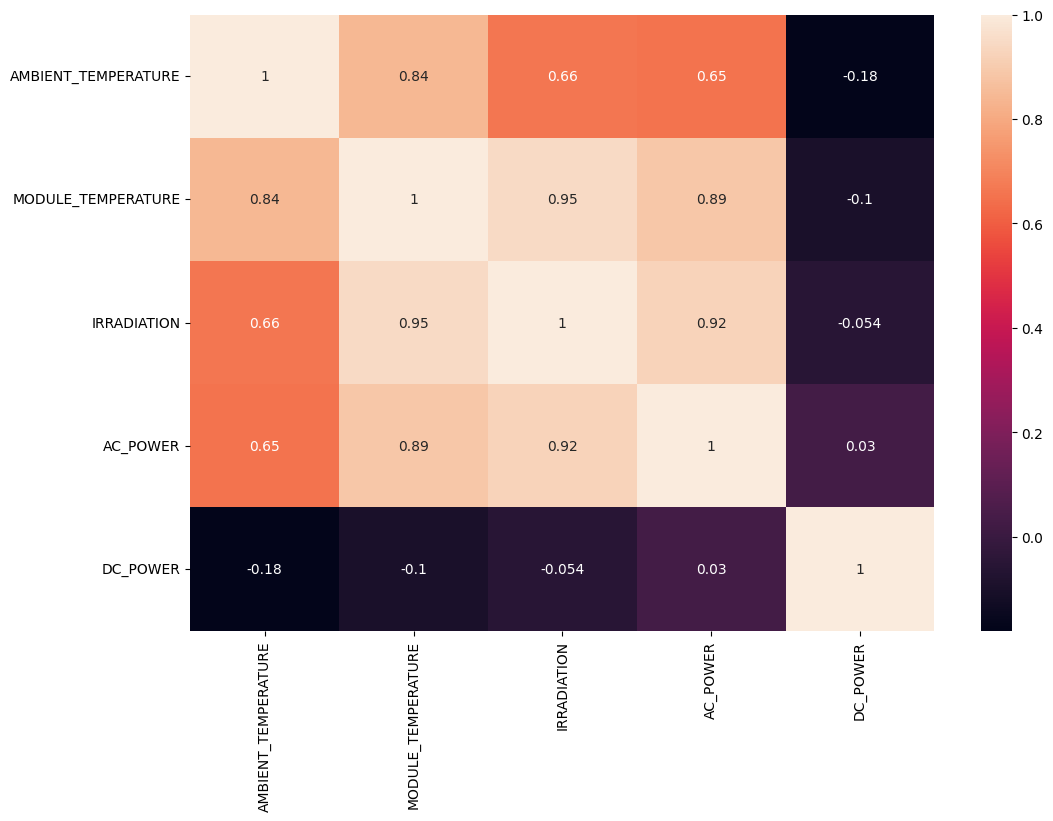

In [25]:
display(df_train.iloc[:,1:].select_dtypes(include=['number']).corr())
plt.figure(figsize = (12,8))
sns.heatmap(df_train[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION',
       'AC_POWER', 'DC_POWER']].corr(),annot=True)

In [26]:
df_train.drop('DC_POWER',axis=1,inplace=True)
percentile_dict = {}
for i in df_train.columns[3:]:
    a_list = []
    for j in [1,10,25,50,75,90,99,100]:
        a_list.append(round(np.percentile(df_train[i],j),2))
    percentile_dict[i] = a_list    
pd.DataFrame(pd.concat([pd.DataFrame({'Percentiles':[1,10,25,50,75,90,99,100]}),pd.DataFrame(percentile_dict)],axis=1)) 

,Percentiles,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER_1,AC_POWER_1,Inverter_No_1,DC_POWER_2,AC_POWER_2,Inverter_No_2,...,DC_POWER_20,AC_POWER_20,Inverter_No_20,DC_POWER_21,AC_POWER_21,Inverter_No_21,DC_POWER_22,AC_POWER_22,Inverter_No_22,AC_POWER
0,1,22.55,21.10,0.00,0.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,0.0,0.00,0.00,22.0,0.00,0.00,0.00
1,10,23.66,22.40,0.00,1.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,0.0,0.00,0.00,22.0,0.00,0.00,0.00
2,25,24.73,23.76,0.00,1.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,0.0,0.00,0.00,22.0,0.00,0.00,0.00
3,50,27.24,27.79,0.02,1.0,0.00,1.21,2.0,0.00,0.00,...,20.0,0.00,0.00,21.0,0.00,170.36,22.0,0.00,0.00,0.47
4,75,31.55,41.75,0.46,1.0,535.66,538.39,2.0,402.93,395.81,...,20.0,482.34,473.00,21.0,312.62,507.60,22.0,426.71,418.87,11.45
5,90,34.61,52.28,0.80,1.0,1024.51,1003.53,2.0,871.89,853.11,...,20.0,961.87,939.29,21.0,844.76,845.51,22.0,883.88,864.01,15.64
6,99,37.40,60.32,0.96,1.0,1313.71,1280.86,2.0,1265.76,1234.17,...,20.0,1289.11,1256.91,21.0,1280.58,1248.68,22.0,1254.15,1223.16,19.99
7,100,39.18,66.64,1.10,1.0,1419.84,1384.35,2.0,1382.21,1347.66,...,20.0,1327.49,1294.30,21.0,1408.86,1373.65,22.0,1406.17,1371.01,26.63


In [27]:
df_train.drop('dc_power', axis=1, inplace=True, errors='ignore')
percentile_dict = {}
for i in df_train.columns[3:]:
    a_list = []
    for j in [1,10,25,50,75,90,99,100]:
        a_list.append(round(np.percentile(df_train[i],j),2))
    percentile_dict[i] = a_list    
pd.DataFrame(pd.concat([pd.DataFrame({'Percentiles':[1,10,25,50,75,90,99,100]}),pd.DataFrame(percentile_dict)],axis=1)) 

,Percentiles,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER_1,AC_POWER_1,Inverter_No_1,DC_POWER_2,AC_POWER_2,Inverter_No_2,...,DC_POWER_20,AC_POWER_20,Inverter_No_20,DC_POWER_21,AC_POWER_21,Inverter_No_21,DC_POWER_22,AC_POWER_22,Inverter_No_22,AC_POWER
0,1,22.55,21.10,0.00,0.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,0.0,0.00,0.00,22.0,0.00,0.00,0.00
1,10,23.66,22.40,0.00,1.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,0.0,0.00,0.00,22.0,0.00,0.00,0.00
2,25,24.73,23.76,0.00,1.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,0.0,0.00,0.00,22.0,0.00,0.00,0.00
3,50,27.24,27.79,0.02,1.0,0.00,1.21,2.0,0.00,0.00,...,20.0,0.00,0.00,21.0,0.00,170.36,22.0,0.00,0.00,0.47
4,75,31.55,41.75,0.46,1.0,535.66,538.39,2.0,402.93,395.81,...,20.0,482.34,473.00,21.0,312.62,507.60,22.0,426.71,418.87,11.45
5,90,34.61,52.28,0.80,1.0,1024.51,1003.53,2.0,871.89,853.11,...,20.0,961.87,939.29,21.0,844.76,845.51,22.0,883.88,864.01,15.64
6,99,37.40,60.32,0.96,1.0,1313.71,1280.86,2.0,1265.76,1234.17,...,20.0,1289.11,1256.91,21.0,1280.58,1248.68,22.0,1254.15,1223.16,19.99
7,100,39.18,66.64,1.10,1.0,1419.84,1384.35,2.0,1382.21,1347.66,...,20.0,1327.49,1294.30,21.0,1408.86,1373.65,22.0,1406.17,1371.01,26.63


In [28]:
cut_blocks = [1,2,3,4,5,6,7,8]
#Bins range
cut_bins =[0, 12, 24, 36, 48, 60, 72, 84, 96]
#Assigning each row to a bin based on BLOCKS
df_train['BIN'] = pd.cut(df_train['BLOCK'], bins=cut_bins, labels = cut_blocks)
display(df_train)

,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER_1,AC_POWER_1,Inverter_No_1,DC_POWER_2,...,AC_POWER_20,Inverter_No_20,DC_POWER_21,AC_POWER_21,Inverter_No_21,DC_POWER_22,AC_POWER_22,Inverter_No_22,AC_POWER,BIN
0,1,2020-05-15,00:00,27.004764,25.060789,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,1
1,2,2020-05-15,00:15,26.880811,24.421869,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,1
2,3,2020-05-15,00:30,26.682055,24.427290,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,1
3,4,2020-05-15,00:45,26.500589,24.420678,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,1
4,5,2020-05-15,01:00,26.596148,25.088210,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966,92,2020-06-14,22:45,24.185657,22.922953,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,8
2967,93,2020-06-14,23:00,24.412542,23.356136,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,8
2968,94,2020-06-14,23:15,24.652915,23.913763,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,8
2969,95,2020-06-14,23:30,24.702391,24.185130,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,8


In [29]:
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


def ANN_model():
    # 3 layered Neural network with 500 epochs and 4 batch size
    reg = Sequential()
    reg.add(Dense(16, input_dim = 3, activation = 'relu'))
    reg.add(Dense(8,kernel_initializer='normal', activation = 'relu'))
    reg.add(Dense(1))
    reg.compile(loss='mean_squared_error', optimizer='adam')
    return reg

ann_regressor = KerasRegressor(build_fn=ANN_model, nb_epoch=500, batch_size=4, verbose=False)

#-----------------------------------X---------------------------------------------------------
#Importing models & Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression  
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

## Pipeline for different Regression models 
pipeline_lr = Pipeline([('lin_regression',LinearRegression())])
pipeline_dt = Pipeline([('dt_regression',DecisionTreeRegressor(random_state=0))])
pipeline_rf = Pipeline([('rf_regression',RandomForestRegressor(random_state=0))])
pipeline_ridge = Pipeline([('ridge_regression',Ridge(random_state=0))])
pipeline_lasso = Pipeline([('lasso_regression',Lasso(random_state=0))])
pipeline_xgboost = Pipeline([('xgboost_regression',XGBRegressor())])
pipeline_ann = Pipeline([('ann_regressor',ann_regressor)])

## Making a list of pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_ridge, pipeline_lasso, pipeline_xgboost, pipeline_ann]

best_rmse = 100.0
best_regressor = 0
best_pipeline = ""

## Dictionary of Pipelines and Regressor types for ease of reference
pipe_dict = {0:'Linear Regression',1: 'Decision Tree Regressor',2:'Random Forest Regressor',
             3:'Ridge Regressor',4:'Lasso Regressor',5:'XG Boost Regressor',6:'ANN Regressor'}


In [32]:
# =========================
# Imports
# =========================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

# TensorFlow Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

# XGBoost
from xgboost import XGBRegressor


# =========================
# ANN Model Function
# =========================
def ANN_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=3))   # input_dim = number of features
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # regression output
    model.compile(optimizer='adam', loss='mse')
    return model


# =========================
# Features & Data
# =========================
useful_features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

# (Assume df_train is already loaded in memory with columns: useful_features + AC_POWER + BIN)
# Example: df_train = pd.read_csv("train.csv")


# =========================
# Define Pipelines
# =========================
ann_regressor = KerasRegressor(build_fn=ANN_model, epochs=50, batch_size=32, verbose=0)

pipelines = [
    Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
    Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.01))]),
    Pipeline([('scaler', StandardScaler()), ('ann', ann_regressor)]),
    Pipeline([('scaler', StandardScaler()), ('xgb', XGBRegressor(
        n_estimators=200, max_depth=5, learning_rate=0.1, random_state=23))])
]

pipe_dict = {
    0: 'Linear Regression',
    1: 'Lasso Regression',
    2: 'Artificial Neural Network',
    3: 'XGBoost Regressor'
}


# =========================
# Cross-Validation with Stratified KFold
# =========================
skf = StratifiedKFold(n_splits=8, random_state=23, shuffle=True)

# Initialize kfold column
df_train['kfold'] = -1

for fold, (train_indices, valid_indices) in enumerate(
        skf.split(X=df_train.iloc[:, :-1], y=df_train['BIN'])):
    df_train.loc[valid_indices, 'kfold'] = fold

best_rmse = np.inf
best_pipeline = None
best_regressor = None

for j, model in enumerate(pipelines):
    RMSE = []

    for i in range(8):
        xtrain = df_train[df_train['kfold'] != i]
        xvalid = df_train[df_train['kfold'] == i]

        ytrain = xtrain.AC_POWER
        yvalid = xvalid.AC_POWER

        xtrain = xtrain[useful_features]
        xvalid = xvalid[useful_features]

        # Fit the pipeline (scaler + model)
        model.fit(xtrain, ytrain)

        # Predictions
        preds = model.predict(xvalid)

        rmse = np.sqrt(mean_squared_error(yvalid, preds))
        RMSE.append(rmse)

    folds_mean_rmse = np.mean(RMSE)
    print(f'Mean Validation RMSE for {pipe_dict[j]}: {folds_mean_rmse}')

    if folds_mean_rmse < best_rmse:
        best_rmse = folds_mean_rmse
        best_pipeline = model
        best_regressor = j


print("\n\nRegressor with least RMSE:", pipe_dict[best_regressor])
print(best_pipeline)


Mean Validation RMSE for Linear Regression: 2.472810281438927
Mean Validation RMSE for Lasso Regression: 2.4778018348903017
Mean Validation RMSE for Artificial Neural Network: 1.7975124822326234
Mean Validation RMSE for XGBoost Regressor: 1.9348460211064422


Regressor with least RMSE: Artificial Neural Network
Pipeline(steps=[('scaler', StandardScaler()),
                ('ann',
                 KerasRegressor(batch_size=32, build_fn=<function ANN_model at 0x000002C3FCB699E0>, epochs=50, verbose=0))])


In [36]:
# Splitting train into x & y
x_train = df_train[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE','IRRADIATION']]
y_train = df_train[['AC_POWER']]

# Random grid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000, 10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 14]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']  # ✅ FIX
}

# Initialize Random Forest
rf = RandomForestRegressor()

# Randomized Search
rf_randomcv = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    verbose=2,
    random_state=100,
    n_jobs=-1
)

# Fit on training data
rf_randomcv.fit(x_train, y_train.values.ravel())   # ✅ .values.ravel() avoids shape errors

# Best parameters found in Random Search
print("Best Parameters:", rf_randomcv.best_params_)

# Train final model with best params
# Train final model with best params
rf_model = RandomForestRegressor(
    n_estimators=1100,
    min_samples_split=14,
    min_samples_leaf=8,
    max_features=None,     # ✅ FIX: use None instead of 'auto'
    max_depth=10,
    criterion='squared_error'
)

# Fitting on train set 
rf_model.fit(x_train, y_train.values.ravel())



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 1000, 'criterion': 'squared_error'}


,n_estimators,1100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,14
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
x_test = df_test[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
y_test = df_test[['AC_POWER']]

#Predicting for x_test
y_pred_rf = rf_model.predict(x_test)

print(f'Root Mean Squared Error for Test Data: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}')


Root Mean Squared Error for Test Data: 1.9421440279755604


   Actual(MW)  Prediction(MW)
0         0.0             0.0
1         0.0             0.0
2         0.0             0.0
3         0.0             0.0
4         0.0             0.0


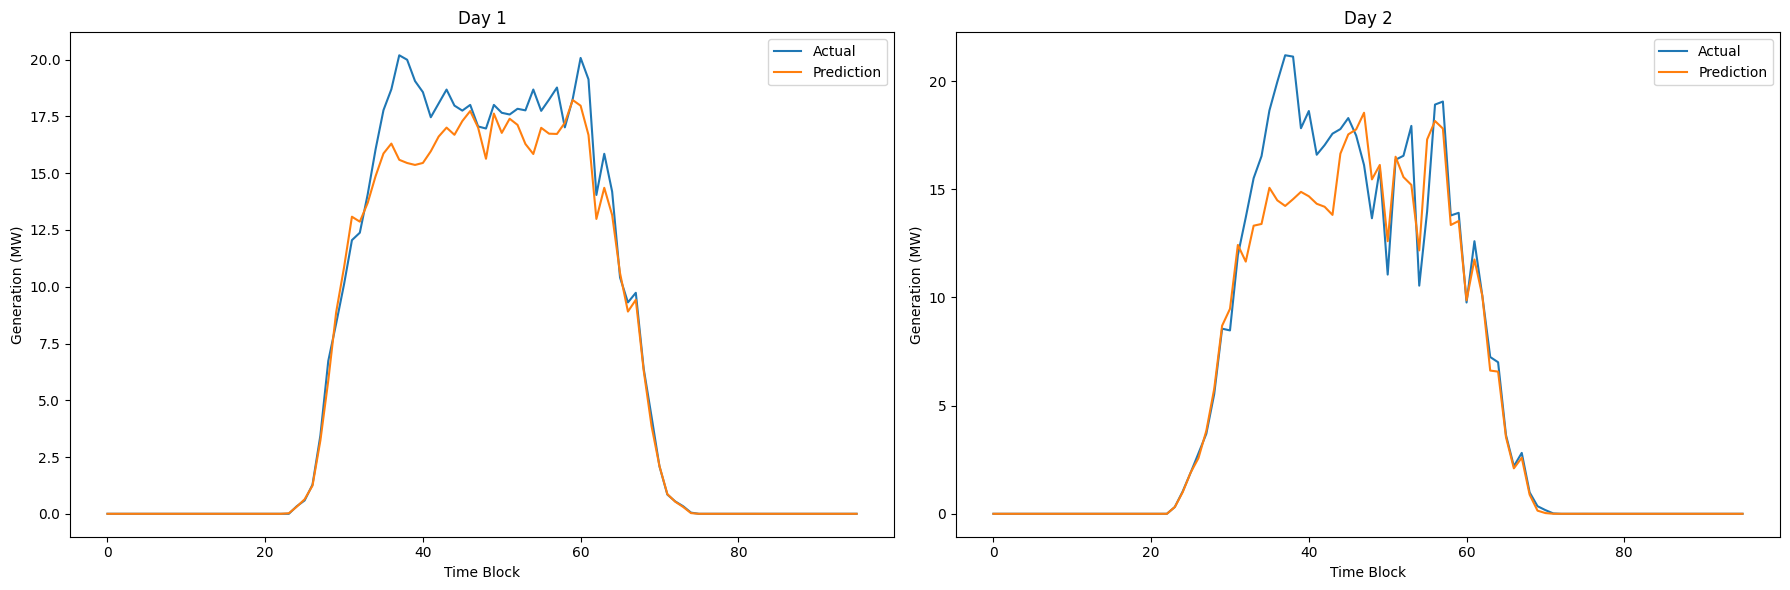

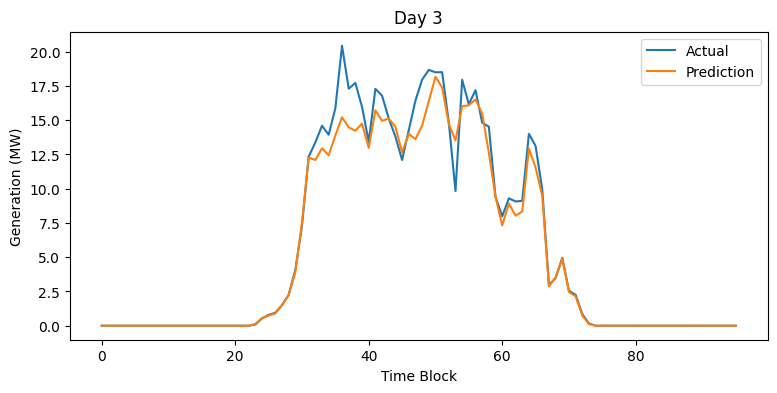

In [40]:
y_pred = rf_model.predict(x_train)

actual_vs_pred = pd.DataFrame({
    "Actual(MW)": y_train.values.ravel(),
    "Prediction(MW)": y_pred
})

print(actual_vs_pred.head())  # sanity check

# =========================
# PLOTTING
# =========================import matplotlib.pyplot as plt

f = plt.figure(figsize=(18,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

# Day 1 (0 to 95)
ax1.plot(actual_vs_pred[['Actual(MW)','Prediction(MW)']][0:96].reset_index(drop=True))
ax1.set_title("Day 1")
ax1.set_xlabel('Time Block')
ax1.set_ylabel('Generation (MW)')
ax1.legend(['Actual','Prediction'])

# Day 2 (96 to 191)
ax2.plot(actual_vs_pred[['Actual(MW)','Prediction(MW)']][96:96*2].reset_index(drop=True))
ax2.set_title("Day 2")
ax2.set_xlabel('Time Block')
ax2.set_ylabel('Generation (MW)')
ax2.legend(['Actual','Prediction'])

plt.tight_layout()
plt.show()

# Day 3 (192 to 287)
plt.figure(figsize=(9,4))
plt.plot(actual_vs_pred[['Actual(MW)','Prediction(MW)']][96*2:96*3].reset_index(drop=True))
plt.title("Day 3")
plt.xlabel('Time Block')
plt.ylabel('Generation (MW)')
plt.legend(['Actual','Prediction'])
plt.show()
